In [1]:
import pandas as pd
import numpy as np

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('IRT//ouirt.dat', sep= ' ', names= cols)
data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [4]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [262]:
rel_items = cols[:3]
df = data[rel_items]
df.head(3)

,Q1,Q2,Q3
0,0,1,1
1,0,1,0
2,0,0,0


In [264]:
df_cols = ['user','questions', 'response']

In [243]:
#pd.DataFrame({'user': list(range(df.shape[0]*3)), 
# 'questions':['Q1']*500+ ['Q2']*500+ ['Q3']*500,'response':pd.concat([df[feat_cols[0]],
# df[feat_cols[1]], df[feat_cols[2]]]).values})

In [63]:
from collections import defaultdict
di = defaultdict(dict)

for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{0:1,1:0,2:0,. . .,}}

In [261]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})

df1=pd.DataFrame(df_list[0])
df2=pd.DataFrame(df_list[1])
df3=pd.DataFrame(df_list[2])
df_new= pd.concat([df1,df2,df3], ignore_index=True)
df_new = df_new.loc[np.random.randint(0,1499, size=1500)]
df_new

,user,questions,response
924,424,Q2,0
464,464,Q1,1
300,300,Q1,1
249,249,Q1,0
491,491,Q1,0
...,...,...,...
639,139,Q2,1
995,495,Q2,0
280,280,Q1,0
1147,147,Q3,1


In [245]:
#df_new['questions']= df_new['questions'].apply(lambda x: 0 if x=='Q1' else 2)

In [269]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

In [313]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [314]:
x_train_user = to_categorical(xtrain['user'])#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (1425, 500) 
shape of x_train_questions: (1425, 3) 
shape of y_train: (1425,)


### 1 PL IRT model

In [378]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input

latent_trait = Dense(100, use_bias=False)(user_input_layer)
difficulty_level = Dense(100, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])



prediction_output = Dense(1, activation='sigmoid')(latent_difficulty_subtract)

model1 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model1.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [379]:
model1.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 100)          50000       input_37[0][0]                   
__________________________________________________________________________________________________
dense_76 (Dense)                (None, 100)          300         input_38[0][0]                   
___________________________________________________________________________________________

In [324]:
x_test_user = to_categorical(xtest['user'].values, num_classes=500)#contains the one-hot encoded user data
x_test_questions = pd.get_dummies(xtest['questions']).values#contains the one-hot encoded questions

y_test= ytest.values
print('shape of x_train_user:', x_test_user.shape,'\nshape of x_train_questions:', x_test_questions.shape,
      '\nshape of y_train:',y_test.shape)

shape of x_train_user: (75, 500) 
shape of x_train_questions: (75, 3) 
shape of y_train: (75,)


In [380]:
history= model1.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 164us/step - loss: 0.6572 - mae: 0.4777 - accuracy: 0.6263 - val_loss: 0.6289 - val_mae: 0.4622 - val_accuracy: 0.6807
Epoch 2/8
1140/1140 [==============================] - 0s 41us/step - loss: 0.6255 - mae: 0.4583 - accuracy: 0.6605 - val_loss: 0.6037 - val_mae: 0.4455 - val_accuracy: 0.7158
Epoch 3/8
1140/1140 [==============================] - 0s 37us/step - loss: 0.6039 - mae: 0.4427 - accuracy: 0.7272 - val_loss: 0.5866 - val_mae: 0.4320 - val_accuracy: 0.7298
Epoch 4/8
1140/1140 [==============================] - 0s 33us/step - loss: 0.5889 - mae: 0.4301 - accuracy: 0.7439 - val_loss: 0.5747 - val_mae: 0.4211 - val_accuracy: 0.7333
Epoch 5/8
1140/1140 [==============================] - 0s 36us/step - loss: 0.5784 - mae: 0.4200 - accuracy: 0.7447 - val_loss: 0.5664 - val_mae: 0.4122 - val_accuracy: 0.7368
Epoch 6/8
1140/1140 [==============================] - 0s 35us/step - lo

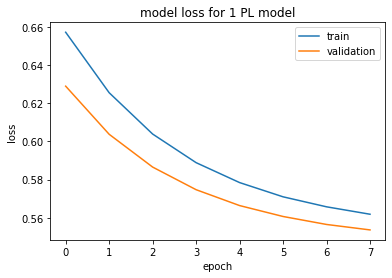

In [381]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for 1 PL model')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 2 PL IRT model

In [375]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input

latent_trait = Dense(100, use_bias=False)(user_input_layer)

difficulty_level = Dense(100, use_bias=False)(quest_input_layer)
discrimination_param = Dense(100, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])


prediction_output = Dense(1, activation='sigmoid')(disc_param_interaction)

model2 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model2.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])
model2.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 100)          50000       input_35[0][0]                   
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 100)          300         input_36[0][0]                   
___________________________________________________________________________________________

In [376]:
history= model2.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 151us/step - loss: 0.6821 - mae: 0.4942 - accuracy: 0.6921 - val_loss: 0.6718 - val_mae: 0.4888 - val_accuracy: 0.7368
Epoch 2/8
1140/1140 [==============================] - 0s 36us/step - loss: 0.6634 - mae: 0.4840 - accuracy: 0.7447 - val_loss: 0.6555 - val_mae: 0.4794 - val_accuracy: 0.7368
Epoch 3/8
1140/1140 [==============================] - 0s 37us/step - loss: 0.6480 - mae: 0.4748 - accuracy: 0.7447 - val_loss: 0.6418 - val_mae: 0.4709 - val_accuracy: 0.7368
Epoch 4/8
1140/1140 [==============================] - 0s 37us/step - loss: 0.6350 - mae: 0.4664 - accuracy: 0.7447 - val_loss: 0.6305 - val_mae: 0.4632 - val_accuracy: 0.7368
Epoch 5/8
1140/1140 [==============================] - 0s 38us/step - loss: 0.6242 - mae: 0.4589 - accuracy: 0.7447 - val_loss: 0.6211 - val_mae: 0.4562 - val_accuracy: 0.7368
Epoch 6/8
1140/1140 [==============================] - 0s 45us/step - lo

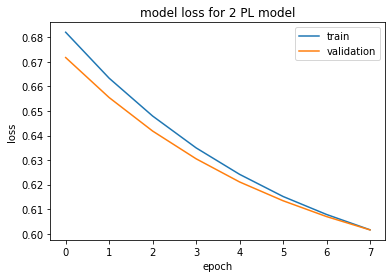

In [377]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for 2 PL model')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 3 PL IRT model

In [338]:
from keras import backend as K

In [360]:
abc= K.constant(value=np.array([-1]))

In [361]:
abc

<tf.Tensor 'Const_40:0' shape=(1,) dtype=float32>

In [344]:
import tensorflow as tf
sess =tf.Session()

In [362]:
sess.run(abc)

array([-1.], dtype=float32)

In [373]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input

latent_trait = Dense(100, use_bias=False)(user_input_layer)

difficulty_level = Dense(100, use_bias=False)(quest_input_layer)
discrimination_param = Dense(100, use_bias=False)(quest_input_layer)
guess_param = Dense(100, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])

guess_param_interaction= keras.layers.Multiply()([K.constant(value=np.array([-1])), guess_param])
guess_param_interaction= keras.layers.Add()([K.constant(value=np.array([1])), guess_param_interaction])
guess_param_interaction= keras.layers.Multiply()([disc_param_interaction, 
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add()([guess_param, guess_param_interaction])


prediction_output = Dense(1, activation='sigmoid')(guess_param_interaction)

#model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

#model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])
#model3.summary()

In [369]:
Model

keras.engine.training.Model

In [374]:
model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'